In [235]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Dropout
from keras.models import Model
from keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline

input_img = Input(shape=(64, 64, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
# x = Dropout(0.5)(x) # This doesn't seem to add anything to performance and makes the latent vector have a lot of redundancy
encoded = MaxPooling2D((2, 2), padding='same', name='latent_layer')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoded.shape[1].value, encoded.shape[2].value, encoded.shape[3].value))
# retrieve the decoder layers of the autoencoder model
decoder_layer = autoencoder.layers[-7](encoded_input)
decoder_layer = autoencoder.layers[-6](decoder_layer)
decoder_layer = autoencoder.layers[-5](decoder_layer)
decoder_layer = autoencoder.layers[-4](decoder_layer)
decoder_layer = autoencoder.layers[-3](decoder_layer)
decoder_layer = autoencoder.layers[-2](decoder_layer)
decoder_layer = autoencoder.layers[-1](decoder_layer)
# create the decoder model
decoder = Model(encoded_input, decoder_layer)

In [244]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 64, 64, 16)        160       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 32, 32, 8)         1160      
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 16, 16, 8)         584       
_________________________________________________________________
latent_layer (MaxPooling2D)  (None, 8, 8, 8)           0         
__________

In [2]:
%cd ../..

/home/kamen/Workspace/Coursework/year4/mlp/mlp-03


In [236]:
from src.datautils.sandia import SandiaDataProvider
import numpy as np

batch_size = 378
train_data = SandiaDataProvider(which_set='train', dataset_home='datasets/sandia', shuffle_order=False)

In [237]:
batch_iterator = train_data.get_batch_iterator(batch_size=batch_size)

X_train, y_train = [x for x in next(batch_iterator)]
X_val, y_val = [x for x in next(batch_iterator)]

X_train = X_train.astype('float32') / 255.
X_val = X_val.astype('float32') / 255.

In [238]:
train_original_images = X_train.transpose(0, 3, 1, 2).reshape((batch_size*16, 64, 64, 1))
val_original_images = X_val.transpose(0, 3, 1, 2).reshape((batch_size*16, 64, 64, 1))
train_images.shape

(6048, 64, 64, 1)

In [239]:
train_noised_images = train_original_images + np.random.randn(*train_original_images.shape) * 1e-1
val_noised_images = val_original_images + np.random.randn(*val_original_images.shape) * 1e-1

In [242]:
%%time
autoencoder.fit(train_images, train_images,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(val_images, val_images))

Train on 6048 samples, validate on 6048 samples
Epoch 1/100
6048/6048 [==============================] - 5s - loss: 0.0866 - val_loss: 0.0850
Epoch 2/100
6048/6048 [==============================] - 5s - loss: 0.0868 - val_loss: 0.0843
Epoch 3/100
6048/6048 [==============================] - 5s - loss: 0.0866 - val_loss: 0.0845
Epoch 4/100
6048/6048 [==============================] - 5s - loss: 0.0868 - val_loss: 0.0831
Epoch 5/100
6048/6048 [==============================] - 5s - loss: 0.0865 - val_loss: 0.0846
Epoch 6/100
6048/6048 [==============================] - 5s - loss: 0.0865 - val_loss: 0.0830
Epoch 7/100
6048/6048 [==============================] - 5s - loss: 0.0856 - val_loss: 0.0836
Epoch 8/100
6048/6048 [==============================] - 5s - loss: 0.0865 - val_loss: 0.0828ss:
Epoch 9/100
6048/6048 [==============================] - 6s - loss: 0.0859 - val_loss: 0.0832
Epoch 10/100
6048/6048 [==============================] - 6s - loss: 0.0863 - val_loss: 0.0839
Epoch 11

6048/6048 [==============================] - 6s - loss: 0.0808 - val_loss: 0.0781
Epoch 87/100
6048/6048 [==============================] - 5s - loss: 0.0810 - val_loss: 0.0769
Epoch 88/100
6048/6048 [==============================] - 5s - loss: 0.0806 - val_loss: 0.0784
Epoch 89/100
6048/6048 [==============================] - 5s - loss: 0.0809 - val_loss: 0.0771
Epoch 90/100
6048/6048 [==============================] - 5s - loss: 0.0803 - val_loss: 0.0778
Epoch 91/100
6048/6048 [==============================] - 5s - loss: 0.0805 - val_loss: 0.0783
Epoch 92/100
6048/6048 [==============================] - 5s - loss: 0.0808 - val_loss: 0.0773
Epoch 93/100
6048/6048 [==============================] - 5s - loss: 0.0803 - val_loss: 0.0769
Epoch 94/100
6048/6048 [==============================] - 5s - loss: 0.0806 - val_loss: 0.0775
Epoch 95/100
6048/6048 [==============================] - 5s - loss: 0.0804 - val_loss: 0.0782
Epoch 96/100
6048/6048 [==============================] - 6s - 

In [248]:
autoencoder.save("models/convolutional_denoising_autoencoder_00.h5")

In [252]:
from keras.models import load_model
autoencoder = load_model("models/convolutional_denoising_autoencoder_00.h5")

In [151]:
embedding = encoder.predict(train_noised_images[0:1, :])

In [152]:
image = decoder.predict(embedding)

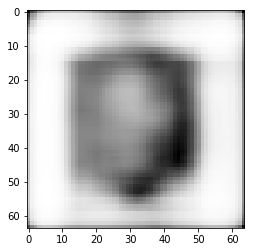

In [153]:
plt.imshow(image[0, :, :, 0])

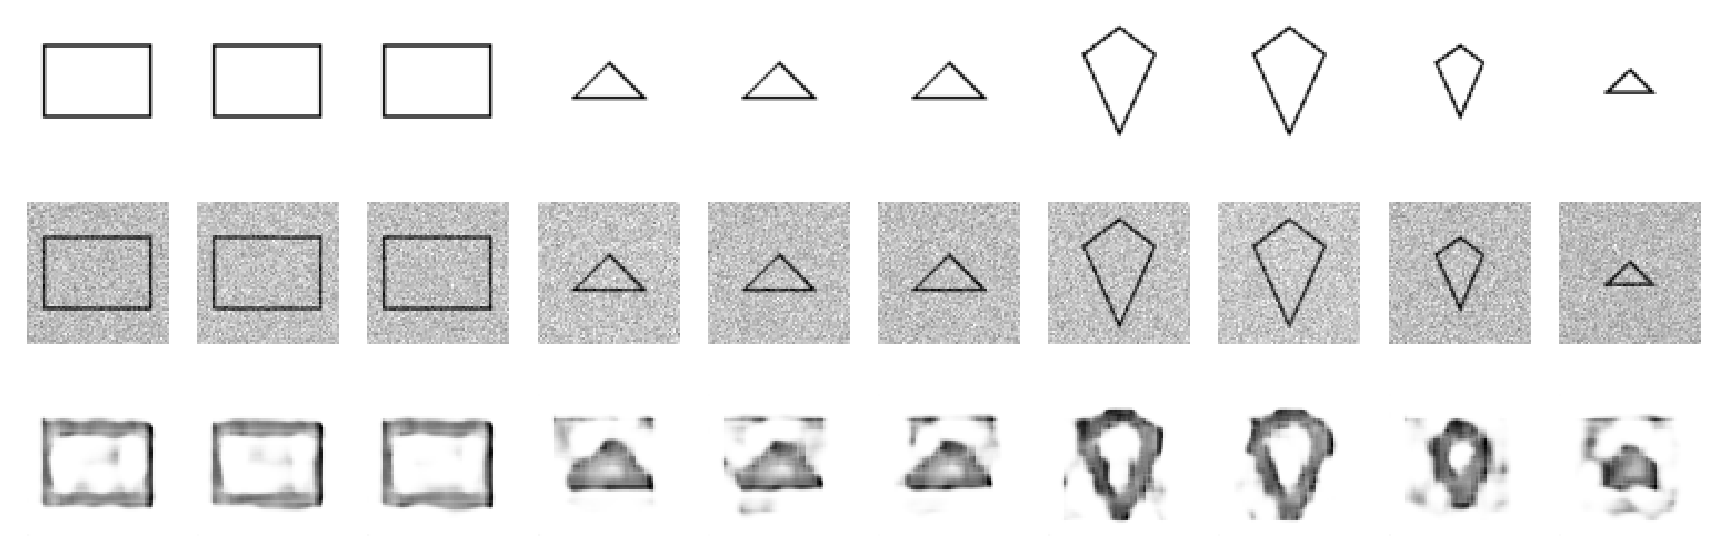

In [253]:
import math

def show_batch_of_images(img_batch, img_size=(1,1), grid_size=None):
    # How many squares for a square grid that can fit all images
    if grid_size == None:
        grid_size = math.ceil(math.sqrt(len(img_batch)))
        grid_size = (grid_size, grid_size)
    fig, axs = plt.subplots(grid_size[0], grid_size[1], figsize=(img_size[0] * grid_size[0], img_size[1] * grid_size[1]))
    # Turn the 2d array of axes to a 1d array
    axs = axs.flatten()
    for i, img in enumerate(img_batch):
        axs[i].imshow(img.reshape(64,64))
    # Do this separately in case the number of images we want to show is not a perfect square
    for i in range(grid_size[0] * grid_size[1]):
        axs[i].axis('off')
    plt.show()

n = 10
originals = val_original_images[:n, :]
noised = val_noised_images[:n, :]
decoded = autoencoder.predict(val_noised_images[:n, :])

show_batch_of_images(np.concatenate([originals, noised, decoded]), img_size=(n, 1), grid_size=(3, n))

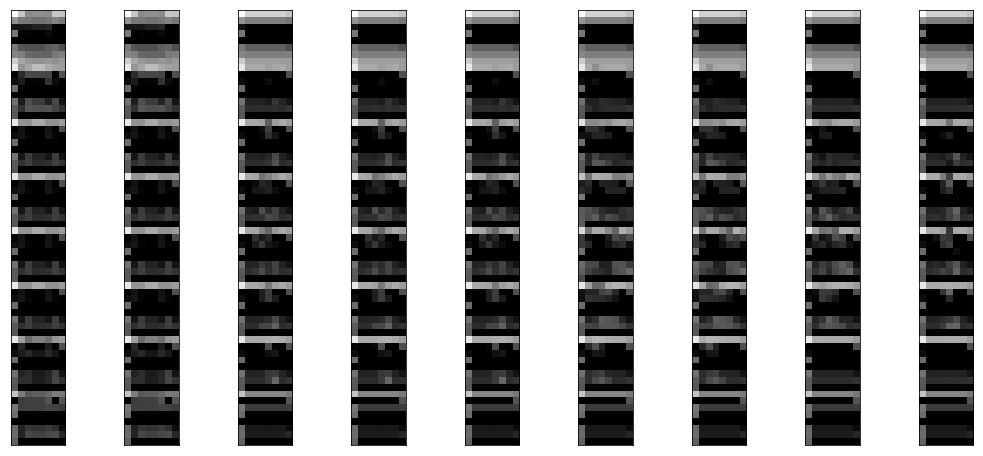

In [231]:
encoded_imgs = encoder.predict(val_images)

n = 10
plt.figure(figsize=(20, 8))
for i in range(1,n):
    ax = plt.subplot(1, n, i)
    plt.imshow(encoded_imgs[i].reshape(8, 8 * 8).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()